## Preprocesamiento y filtrado de moléculas generadas por un modelo VAE

En este proyecto trabajamos con un conjunto de moléculas generadas automáticamente por un modelo de tipo VAE (*Variational Autoencoder*), almacenadas como cadenas SMILES en un archivo CSV. Nuestro objetivo es filtrar y preparar estas moléculas para seleccionar aquellas que podrían tener propiedades compatibles con un uso farmacológico.

A continuación, se describen los pasos seguidos para limpiar y filtrar las moléculas, con énfasis en las reglas de Lipinski, que nos permiten descartar compuestos poco prometedores.


Primero, usamos la librería `pandas` para leer el archivo `molecules.csv`, que contiene una columna con las moléculas generadas en formato SMILES. También leemos el archivo de las moléculas ya existentes en la base de datos `e_coli_molecules.csv` que contiene una columna con las moléculas en forma canónica.


In [24]:
import pandas as pd

# Moléculas generadas
molecules = pd.read_csv("molecules.csv")
print(f"Moléculas generadas: {len(molecules)}")
print(molecules.head())

# Moléculas conocidas contra E.coli
molecules_known = pd.read_csv("e_coli_molecules.csv")
print(f"Moléculas conocidas: {len(molecules_known)}")
print(molecules_known.head())


Moléculas generadas: 1230
  generated_smiles
0              CCO
1       COC1=CC=C1
2          CC1C=N1
3             CCCC
4              C=C
Moléculas conocidas: 1405
                              canonical_smiles molecule_chembl_id relation  \
0  CC1(C)N=C(N)N=C(N)N1c1cccc(C[Se]c2ccccc2)c1        CHEMBL20224        =   
1                   COCc1cccc(Cc2cnc(N)nc2N)c1        CHEMBL31462        =   
2                    COc1ccc(Cc2cnc(N)nc2N)cc1        CHEMBL19023        =   
3             CCCCCCCCOc1cccc(Cc2cnc(N)nc2N)c1        CHEMBL31235        =   
4                   Nc1ncc(Cc2cccc(O)c2)c(N)n1        CHEMBL30734        =   

  standard_relation standard_type standard_units  standard_value  \
0                 =            Ki             nM           3.802   
1                 =  Log 1/Ki app            NaN           6.590   
2                 =  Log 1/Ki app            NaN           6.820   
3                 =  Log 1/Ki app            NaN           6.250   
4                 =  Log 

### 1. Eliminación de duplicados y comparación con moléculas conocidas

En esta primera etapa, preprocesamos el conjunto de moléculas generadas por el modelo para asegurar su validez y unicidad, y comparamos los compuestos resultantes con la base de datos de moléculas conocidas activas contra *Escherichia coli*. Esta comparación inicial nos permite verificar si el modelo ha generado alguna molécula **ya conocida**.

**¿Por qué es necesario este paso?**

Los modelos generativos, como los basados en autoencoders variacionales (VAE), suelen producir moléculas que:

- Son **estructuralmente inválidas**, es decir, no representan una molécula química real.
- Son **duplicadas**.
- Pueden coincidir con **moléculas ya existentes**, lo que puede ser deseable (si se redescubre algo útil) o redundante (si buscamos exclusivamente novedad).

**SMILES y la necesidad de canonización**

Las moléculas se representan mediante cadenas **SMILES** (*Simplified Molecular Input Line Entry System*), una notación en texto que codifica estructuras químicas. Sin embargo, una misma molécula puede tener múltiples representaciones SMILES diferentes dependiendo del orden de los átomos.

Para abordar este problema, usamos **SMILES canónicos**, una forma normalizada y única de representar una molécula. Esto nos permite:

- Identificar duplicados aunque tengan un orden distinto en su representación textual.
- Comparar directamente moléculas generadas con una base de datos de referencia.

**¿Qué hacemos en esta sección?**

1. **Convertimos los SMILES generados en objetos `Mol` válidos** usando la librería RDKit.
2. **Obtenemos la forma canónica** de cada molécula.
3. **Eliminamos moléculas inválidas** (que no se pudieron parsear).
4. **Eliminamos duplicados exactos** dentro del conjunto generado.
5. **Comparamos con las moléculas conocidas activas contra *E. coli*** para detectar coincidencias exactas.


In [27]:
from rdkit import Chem

# Convertir SMILES a objetos Mol
molecules["mol"] = molecules["generated_smiles"].apply(Chem.MolFromSmiles)

# Obtener la forma canónica de cada molécula
molecules["canonical_smiles"] = molecules["mol"].apply(
    lambda mol: Chem.MolToSmiles(mol, canonical=True) if mol else None
)

print(molecules.head())

# Eliminar moléculas no convertibles (inválidas)
molecules = molecules.dropna(subset=["canonical_smiles"])

# Eliminar duplicados exactos
molecules = molecules.drop_duplicates(subset=["canonical_smiles"])

# Comomparamos con las moléculas conocidas activas
duplicated_with_known = molecules[
    molecules["canonical_smiles"].isin(molecules_known["canonical_smiles"])
]

print(f"Se encontraron {len(duplicated_with_known)} duplicados exactos con las moléculas conocidas.")

# Eliminar del conjunto generado las moléculas que ya existen en la base de datos conocida
molecules = molecules[~molecules["canonical_smiles"].isin(molecules_known["canonical_smiles"])]

print(f"Total de moléculas generadas:{len(molecules)}")

  generated_smiles                                                mol  \
0              CCO  <rdkit.Chem.rdchem.Mol object at 0x000001CA136...   
1       COC1=CC=C1  <rdkit.Chem.rdchem.Mol object at 0x000001CA136...   
2          CC1C=N1  <rdkit.Chem.rdchem.Mol object at 0x000001CA136...   
3             CCCC  <rdkit.Chem.rdchem.Mol object at 0x000001CA136...   
4              C=C  <rdkit.Chem.rdchem.Mol object at 0x000001CA136...   

  canonical_smiles  
0              CCO  
1       COC1=CC=C1  
2          CC1C=N1  
3             CCCC  
4              C=C  
Se encontraron 18 duplicados exactos con las moléculas conocidas.
Total de moléculas generadas:435


Este paso asegura que solo trabajamos con moléculas químicamente válidas y únicas.

### 2. Definir el filtro de Lipinski

Las reglas de Lipinski, también conocidas como **"regla de los cinco"**, son un conjunto de criterios utilizados para evaluar si una molécula tiene propiedades compatibles con la administración oral en humanos.

Estas reglas no garantizan que una molécula sea un fármaco, pero son útiles para filtrar compuestos poco prometedores.

Las reglas son las siguientes:

| Propiedad                       | Umbral                 | Descripción                                                                 |
|--------------------------------|------------------------|-----------------------------------------------------------------------------|
| Peso molecular (MolWt)         | < 500 daltons          | Moléculas grandes suelen absorberse mal                                     |
| LogP (MolLogP)                 | < 5                    | Alta lipofilia puede reducir la solubilidad y aumentar la toxicidad        |
| Número de donadores de H (HBD) | ≤ 5                    | Muchas interacciones de H reducen la permeabilidad celular                 |
| Número de aceptores de H (HBA) | ≤ 10                   | Exceso de aceptores también puede dificultar la absorción oral             |

Implementamos esta regla como una función que calcula estos descriptores usando `RDKit`.

In [28]:
from rdkit.Chem import Descriptors
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)                     # Peso molecular
    logp = Descriptors.MolLogP(mol)                 # Hidrofobicidad
    h_donors = Descriptors.NumHDonors(mol)          # Donadores de hidrógeno
    h_acceptors = Descriptors.NumHAcceptors(mol)    # Aceptores de hidrógeno
    return (mw < 500 and logp < 5 and h_donors <= 5 and h_acceptors <= 10)

# Aplicar filtro
molecules['passes_lipinski'] = molecules['mol'].apply(passes_lipinski)
molecules_filtered = molecules[molecules['passes_lipinski']]
print(f"Después del filtrado Lipinski: {len(molecules_filtered)} moléculas")

Después del filtrado Lipinski: 432 moléculas


Este preprocesamiento constituye un primer filtrado fundamental antes de aplicar otros métodos más avanzados como predicción de propiedades ADMET o similitud estructural

### 3. Evaluar la similitud estructural con moléculas conocidas contra *E. coli*

Para evaluar si las nuevas moléculas generadas por el modelo podrían ser relevantes como antibacterianos, es útil compararlas con compuestos **ya conocidos como activos frente a *E. coli***. Una forma estándar de hacerlo es mediante la **similitud estructural** basada en *fingerprints moleculares* y una métrica llamada **similitud de Tanimoto**.

**¿Qué es la similitud de Tanimoto?**

>La similitud de Tanimoto (también llamada índice de Jaccard para vectores binarios) mide cuán similares son dos vectores binarios, como los generados por los fingerprints moleculares. Se define como:
>
>$$
>\text{Tanimoto}(A, B) = \frac{A \cdot B}{|A|^2 + |B|^2 - A \cdot B}
>$$
>
>Donde:
>- $A$ y $B$ son dos vectores de bits (fingerprints),
>- $A \cdot B$ es el número de bits en común (intersección),
>- $|A|$ y $|B|$ son el número total de bits activados (unión).
>
>Su valor está entre 0 (sin semejanza) y 1 (idénticos).

**¿Qué son los fingerprints de Morgan?**

>Los fingerprints de Morgan (también conocidos como ECFP, *Extended Connectivity Fingerprints*) codifican la **estructura local** de los átomos y sus vecinos en una molécula. Son especialmente útiles en tareas de *similaridad molecular* y *descubrimiento de fármacos*.


1405


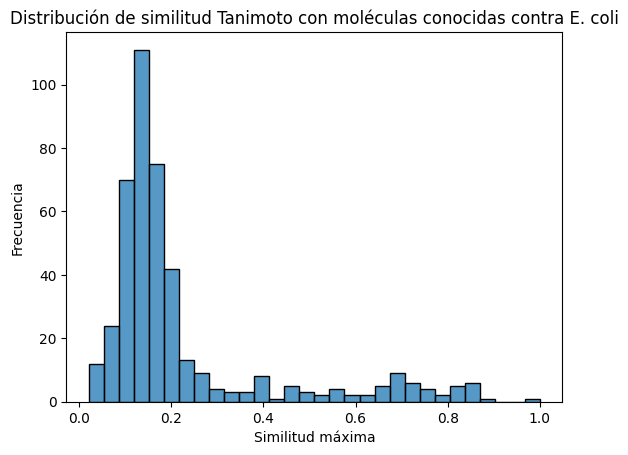

In [31]:
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import TanimotoSimilarity

# --- Paso 1: Convertir las moléculas conocidas a objetos RDKit ---
molecules_known['mol'] = molecules_known['canonical_smiles'].apply(Chem.MolFromSmiles)
print(len(molecules_known))

# --- Paso 2: Obtener fingerprints de Morgan (ECFP) ---
# Crear el generador con:
#    radius=2: número de saltos de átomos alrededor de cada átomo central
#    fpSize=2048: tamaño del vector binario (número de bits) del fingerprint.
# Equivalente a los populares ECFP4, comúnmente usados en drug discovery
morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

# Usar el generador para obtener los fingerprints
known_fps = [morgan_gen.GetFingerprint(mol) for mol in molecules_known['mol']]
generated_fps = molecules['mol'].apply(lambda mol: morgan_gen.GetFingerprint(mol))

# --- Paso 3: Calcular la máxima similitud Tanimoto con las conocidas ---
# Definimos una función que recibe un fingerprint y devuelve la máxima similitud Tanimoto entre él y los fingerprints de las moléculas conocidas.
def max_tanimoto(fp, known_fps):
    return max([TanimotoSimilarity(fp, known_fp) for known_fp in known_fps])

molecules['max_tanimoto'] = generated_fps.apply(lambda fp: max_tanimoto(fp, known_fps))

# --- (Opcional) Ver distribución de similitudes ---
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(molecules_filtered['max_tanimoto'], bins=30)
plt.title("Distribución de similitud Tanimoto con moléculas conocidas contra E. coli")
plt.xlabel("Similitud máxima")
plt.ylabel("Frecuencia")
plt.show()


- La mayoría de las moléculas tienen una similitud Tanimoto baja, principalmente entre 0.1 y 0.3, lo que indica que las estructuras evaluadas son bastante diferentes de los compuestos previamente conocidos. Esto puede ser positivo si se busca diversidad química o nuevas estructuras activas.

- Existe una cola larga hacia la derecha, con algunas moléculas que presentan una similitud superior a 0.6, lo cual sugiere cierto grado de analogía estructural con moléculas activas conocidas.

- Se observan unos pocos compuestos con similitud cercana a 1. Aunque no deberían ser exactamente iguales (ya que las moléculas conocidas se excluyen del conjunto a evaluar), esta similitud tan alta podría indicar:

    - Posibles duplicados en los datos (a revisar).
    - Moléculas muy similares pero con diferencias menores 
    - Buenas candidatas para reposicionamiento o validación de la metodología.

In [37]:
# --- Paso 4: Revisar posibles duplicados basados en similitud alta (> 0.95) ---
from rdkit.Chem import Draw

# Guardar matches sospechosos: (índice evaluado, índice conocido, similitud)
duplicados = []

for idx_query, fp in enumerate(generated_fps):
    sims = [TanimotoSimilarity(fp, known_fp) for known_fp in known_fps]
    max_sim = max(sims)
    if max_sim > 0.95:
        idx_known = sims.index(max_sim)
        duplicados.append((idx_query, idx_known, max_sim))

# Mostrar resumen
print(f"Se encontraron {len(duplicados)} moléculas con similitud > 0.95 (posibles duplicados).")

# Seleccionar la molécula que tiene similitud > 0.95
mol_sospechosa = molecules[molecules['max_tanimoto'] > 0.95].iloc[0]

# Mostrar su SMILES
print("SMILES de la molécula sospechosa:", mol_sospechosa['canonical_smiles'])

# Buscar en el dataset conocido si hay alguna con ese mismo SMILES
duplicado_exacto = molecules_known[molecules_known['canonical_smiles'] == mol_sospechosa['canonical_smiles']]

# Mostrar resultado
if not duplicado_exacto.empty:
    print("Se encontró una coincidencia exacta en el dataset de referencia.")
    display(duplicado_exacto)
else:
    print("No hay coincidencias exactas en el dataset de referencia (similitud alta pero no idéntica).")

Se encontraron 1 moléculas con similitud > 0.95 (posibles duplicados).
SMILES de la molécula sospechosa: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1
No hay coincidencias exactas en el dataset de referencia (similitud alta pero no idéntica).


### Entrenar un modelo de predicción de acitividad

Opción 1: Clasificación (alta vs. baja actividad)

Opción 2: Regresión

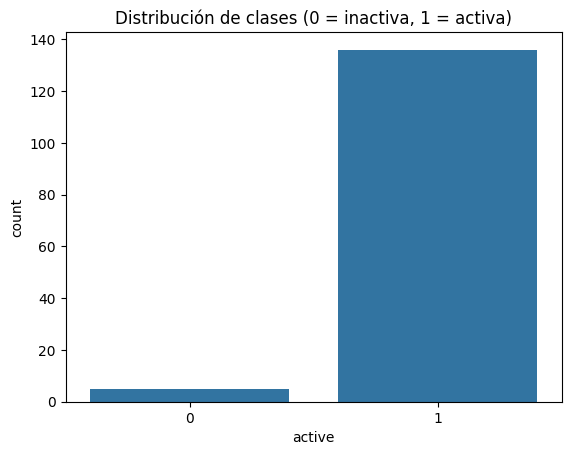

Accuracy en test: 0.9655172413793104
Se predicen 435 moléculas activas nuevas.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Filtrar las moléculas conocidas con actividad Log 1/Ki app
df_model = molecules_known[molecules_known["type"] == "Log 1/Ki app"].copy()

# 2. Etiquetar: activa si value >= 6.0
threshold = 6.0
df_model["active"] = (df_model["value"] >= threshold).astype(int)

# 3. Filtrar los fingerprints correspondientes
indices = df_model.index
X_known = np.array([list(known_fps[i]) for i in indices])
y = df_model["active"].values

# 4. Entrenar el modelo de clasificación
X_train, X_test, y_train, y_test = train_test_split(X_known, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
print("Accuracy en test:", clf.score(X_test, y_test))

X_new = np.array([list(fp) for fp in generated_fps])
# 6. Predecir actividad
preds = clf.predict(X_new)
probs = clf.predict_proba(X_new)[:, 1]  # probabilidad de ser activa

molecules["predicted_active"] = preds
molecules["prob_active"] = probs

actives = molecules[molecules["predicted_active"] == 1]
print(f"Se predicen {len(actives)} moléculas activas nuevas.")

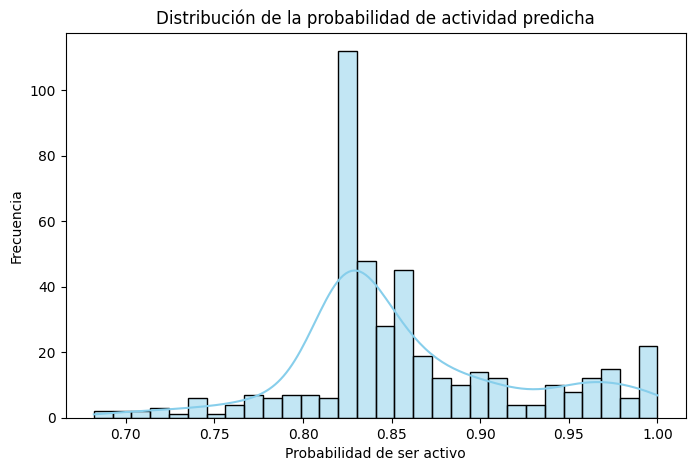

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(probs, bins=30, kde=True, color='skyblue')
plt.title("Distribución de la probabilidad de actividad predicha")
plt.xlabel("Probabilidad de ser activo")
plt.ylabel("Frecuencia")
plt.show()

Número de moléculas por nivel de actividad estimada:
activity_level
Baja       3
Media    328
Alta     104
Name: count, dtype: int64


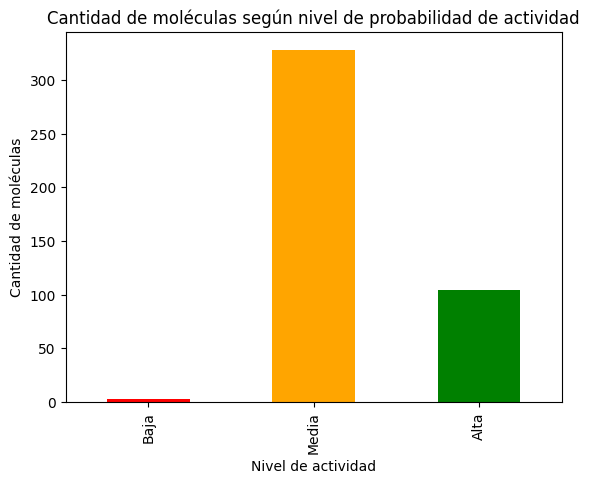

In [52]:
import pandas as pd

molecules["activity_level"] = pd.cut(probs, bins=[0, 0.7, 0.9, 1.0], labels=["Baja", "Media", "Alta"])
counts = molecules["activity_level"].value_counts().sort_index()

print("Número de moléculas por nivel de actividad estimada:")
print(counts)

# Gráfico de barras
counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Cantidad de moléculas según nivel de probabilidad de actividad")
plt.xlabel("Nivel de actividad")
plt.ylabel("Cantidad de moléculas")
plt.show()

Similitud máxima en moléculas con alta probabilidad:
count    104.000000
mean       0.416427
std        0.256099
min        0.111111
25%        0.177778
50%        0.343750
75%        0.668605
max        1.000000
Name: max_tanimoto, dtype: float64

Similitud máxima en moléculas con baja o media probabilidad:
count    331.000000
mean       0.162719
std        0.121285
min        0.021277
25%        0.108108
50%        0.135802
75%        0.171080
max        0.829268
Name: max_tanimoto, dtype: float64


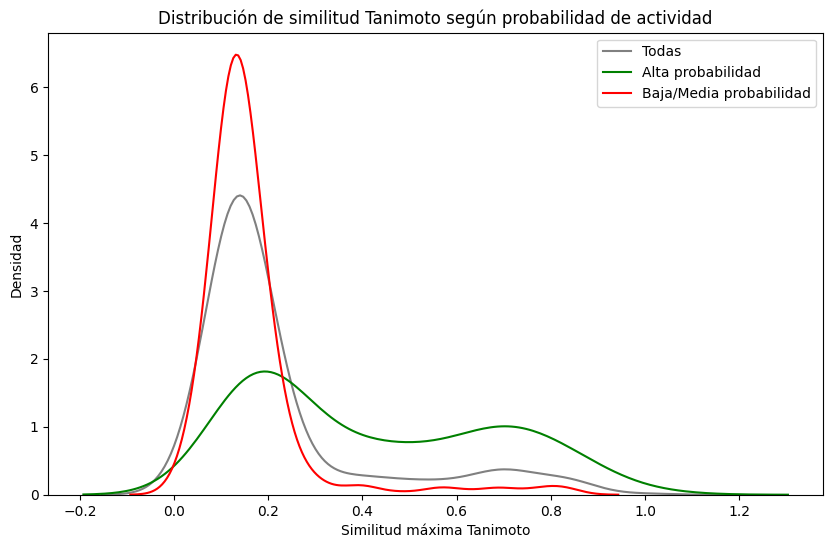

In [53]:
# Filtrar moléculas con probabilidad alta
high_prob_mols = molecules[molecules["prob_active"] > 0.9]

# Estadísticas de similitud en ese grupo
print("Similitud máxima en moléculas con alta probabilidad:")
print(high_prob_mols["max_tanimoto"].describe())

# Comparar con el resto
low_prob_mols = molecules[molecules["prob_active"] <= 0.9]

print("\nSimilitud máxima en moléculas con baja o media probabilidad:")
print(low_prob_mols["max_tanimoto"].describe())

# Visualización comparativa
plt.figure(figsize=(10,6))
sns.kdeplot(molecules["max_tanimoto"], label='Todas', color='gray')
sns.kdeplot(high_prob_mols["max_tanimoto"], label='Alta probabilidad', color='green')
sns.kdeplot(low_prob_mols["max_tanimoto"], label='Baja/Media probabilidad', color='red')
plt.xlabel("Similitud máxima Tanimoto")
plt.ylabel("Densidad")
plt.title("Distribución de similitud Tanimoto según probabilidad de actividad")
plt.legend()
plt.show()


#### Análisis de resultados del grupo 1 y grupo 2

##### Grupo 1: Moléculas con alta probabilidad (> 0.9)

- **Número:** 104 moléculas  
- **Media (mean):** ~0.42  
- **Mediana (50%):** 0.34  
- **75% (Q3):** 0.67  
- **Máximo:** 1.0 (moléculas idénticas o muy similares a conocidas)  
- **Mínimo:** 0.11 (moléculas poco similares)  

**Interpretación:**  
- En promedio, estas moléculas presentan una similitud moderada con las moléculas conocidas (42%).  
- La mediana indica que la molécula típica tiene alrededor de un 34% de similitud, un valor no muy alto pero significativo.  
- El cuartil superior (75%) muestra que al menos un 25% de las moléculas tienen una similitud bastante alta (más del 67%), representando un grupo químicamente cercano a las moléculas conocidas.  
- Existen algunas moléculas con similitud baja (mínimo 11%), que podrían representar estructuras novedosas o posibles falsos positivos del modelo.

##### Grupo 2: Moléculas con baja o media probabilidad (≤ 0.9)

- **Número:** 331 moléculas  
- **Media:** ~0.16  
- **Mediana:** 0.14  
- **75%:** 0.17  
- **Máximo:** 0.83  
- **Mínimo:** 0.02  

**Interpretación:**  
- Este grupo presenta una similitud media mucho menor con las moléculas conocidas (16%).  
- La mediana confirma que la mayoría son poco similares (14%).  
- El valor máximo no es muy alto (83%), lo que indica que pocas moléculas con baja o media probabilidad son estructuralmente parecidas a las conocidas.

#### Conclusiones

1. **Relación positiva entre probabilidad de actividad y similitud química:**  
   Las moléculas que el modelo considera más activas (alta probabilidad) tienden a ser más similares a las moléculas conocidas activas, aunque la similitud media no es altísima. Esto sugiere que el modelo está utilizando características relacionadas con la estructura química para predecir actividad.

2. **Posible descubrimiento de moléculas novedosas:**  
   Algunas moléculas con alta probabilidad presentan baja similitud con conocidas, lo que indica que el modelo puede identificar compuestos potencialmente novedosos, aunque con cierto riesgo de falsos positivos.

3. **Consistencia en la predicción para moléculas no similares:**  
   Las moléculas con baja o media probabilidad son, en su mayoría, poco similares a las conocidas, lo que sugiere que el modelo descarta adecuadamente compuestos no relacionados estructuralmente.

                                               SMILES
0                      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C
1                       CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1
2                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
3                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC
4                     CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC
5                        COc1cc(C)cc(Cc2cnc(N)nc2N)c1
6                  CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC
7   CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...
8                     CNc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
9                    CCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC
10                                         COC1=CC=C1
11                    CCc1c(OC)cc(Cc2cnc(N)cc2N)cc1OC
12                                               CCOC
13                                COC1=CC=CC(=N)C=CC1
14                                    CCCOC1=CC=CC1OC
15                    CNc1c(OC)cc(Cc2ccc(N)nc2N)cc1OC
16                                               COCN
17                       COc

C:\Temporales Windows\ipykernel_1628\481217204.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_high_sim_top10["group"] = "high_sim"
C:\Temporales Windows\ipykernel_1628\481217204.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_low_sim_top10["group"] = "low_sim"


,canonical_smiles,prob_active,max_tanimoto
16,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C,0.970182,0.825000
101,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1,0.924651,0.837838
244,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,1.000000,0.850000
284,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC,0.970182,0.875000
306,CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC,0.990000,0.857143
896,COc1cc(C)cc(Cc2cnc(N)nc2N)c1,0.961472,0.837838
917,CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC,0.990000,0.866667
922,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...,0.950122,1.000000
1043,CNc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,0.990000,0.804878
1229,CCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC,1.000000,0.857143


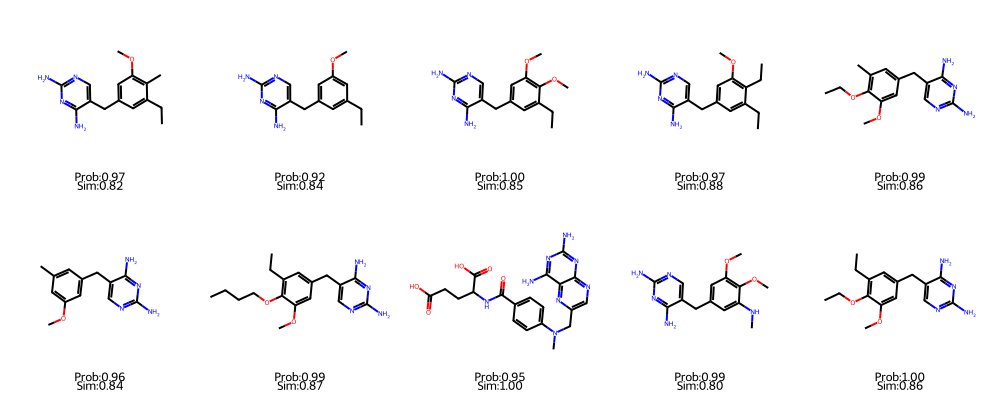


Moléculas con Alta Probabilidad y Baja Similitud



,canonical_smiles,prob_active,max_tanimoto
1,COC1=CC=C1,0.931951,0.170213
8,CCc1c(OC)cc(Cc2cnc(N)cc2N)cc1OC,0.960182,0.743590
10,CCOC,0.913035,0.153846
17,COC1=CC=CC(=N)C=CC1,0.931951,0.150000
41,CCCOC1=CC=CC1OC,0.913663,0.230769
45,CNc1c(OC)cc(Cc2ccc(N)nc2N)cc1OC,0.980182,0.717949
48,COCN,0.901594,0.162162
67,COc1ccc2c(c1)CN=C(F)N=C(N)C2,1.000000,0.309091
69,COc1cc(Cc2ccc(N)nc2N)cc(OC)c1OC,1.000000,0.756757
81,Nc1c[nH]c2ccc(cc2)cn1,0.970122,0.191489


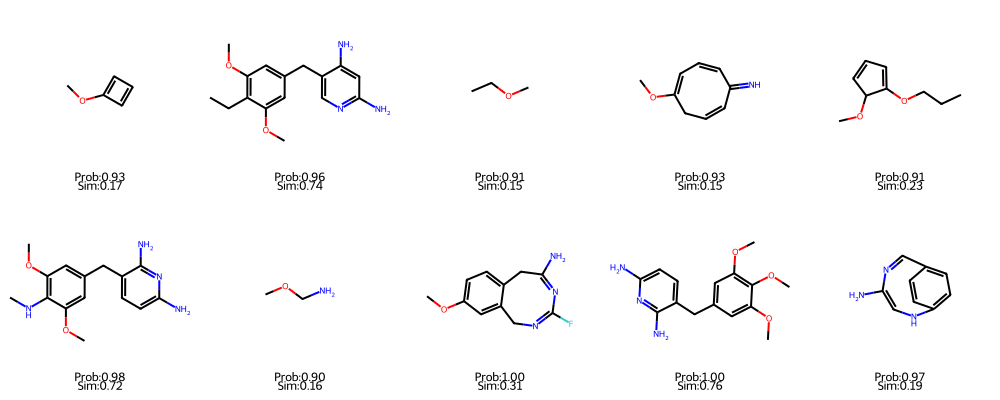

In [ ]:
from rdkit.Chem import Draw

# Definir los umbrales para alta probabilidad y alta/baja similitud
prob_threshold = 0.9
similarity_threshold = 0.8  # puedes ajustar este valor para definir "alta" similitud

# Filtrar moléculas con alta probabilidad y alta similitud
high_prob_high_sim = molecules[(molecules['prob_active'] >= prob_threshold) & 
                            (molecules['max_tanimoto'] >= similarity_threshold)].copy()

# Filtrar moléculas con alta probabilidad y baja similitud
high_prob_low_sim = molecules[(molecules['prob_active'] >= prob_threshold) & 
                            (molecules['max_tanimoto'] < similarity_threshold)].copy()

# Seleccionar las 10 primeras de cada grupo
high_prob_high_sim_top10 = high_prob_high_sim.head(10)
high_prob_low_sim_top10 = high_prob_low_sim.head(10)
high_prob_high_sim_top10["group"] = "high_sim"
high_prob_low_sim_top10["group"] = "low_sim"
smiles_df = pd.concat([high_prob_high_sim_top10, high_prob_low_sim_top10], ignore_index=True)
smiles_only_df = smiles_df[['generated_smiles']]
smiles_only_df.columns = ["SMILES"]
print(smiles_only_df)
smiles_only_df.to_csv("molecules_admetlab.csv", index=False)
# Visualización con RDKit (muestra SMILES + índice)
def mostrar_moleculas(df, titulo):
    print(f"\n{titulo}\n")
    display(df[['canonical_smiles', 'prob_active', 'max_tanimoto']])
    mols = list(df['mol'])
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200),
                            legends=[f"Prob:{p:.2f}\nSim:{s:.2f}" 
                                        for p,s in zip(df['prob_active'], df['max_tanimoto'])])
    display(img)

# Mostrar y almacenar
mostrar_moleculas(high_prob_high_sim_top10, "Moléculas con Alta Probabilidad y Alta Similitud")
mostrar_moleculas(high_prob_low_sim_top10, "Moléculas con Alta Probabilidad y Baja Similitud")

In [74]:
# Cargar resultados de ADMETlab
admet_df = pd.read_csv("admet_results.csv")

# Añadir el grupo de vuelta (asumiendo mismo orden)
admet_df["group"] = smiles_df["group"].values
admet_df["generated_smiles"] = smiles_df["generated_smiles"].values
print(admet_df)
print(admet_df.columns.tolist())

                                               smiles      MW         Vol  \
0                      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C  272.16  287.841835   
1                       CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1  258.15  270.545850   
2                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC  288.16  296.632062   
3                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC  286.18  305.137820   
4                     CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC  288.16  296.632062   
5                        COc1cc(C)cc(Cc2cnc(N)nc2N)c1  244.13  253.249865   
6                  CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC  330.21  348.520018   
7   CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...  454.17  431.730958   
8                     CNc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC  289.15  290.332837   
9                    CCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC  302.17  313.928047   
10                                         COC1=CC=C1   82.04   89.997235   
11                    CCc1c(OC)cc(Cc2cnc(N)cc2N)cc1OC  287.16  302.931287   

In [50]:
### Modelo de Regresión

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# 1. Filtrar las moléculas conocidas con valores de Log 1/Ki app
df_model = molecules_known[molecules_known["type"] == "Log 1/Ki app"].copy()
y = df_model["value"].astype(float)

# 2. Obtener los fingerprints correspondientes
indices = df_model.index
X_known = np.array([list(known_fps[i]) for i in indices])

# 3. Entrenar modelo de regresión
X_train, X_test, y_train, y_test = train_test_split(X_known, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# 4. Evaluar modelo
y_pred = reg.predict(X_test)
print("R² en test:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# 5. Aplicar el modelo a moléculas generadas
X_new = np.array([list(fp) for fp in generated_fps])
preds = reg.predict(X_new)

molecules["predicted_value"] = preds
molecules["predicted_active"] = (preds >= 6.0).astype(int)

# Mostrar resultados
active_candidates = molecules[molecules["predicted_active"] == 1]
print(f"Se predicen {len(active_candidates)} moléculas generadas como activas.")

R² en test: 0.7724402998990204
RMSE: 0.4123468225809686
Se predicen 434 moléculas generadas como activas.
